In [1]:
# Importing the libraries
import numpy as np
from task import Task

In [2]:
# Setting the Hyper Parameters

class Hp():

    def __init__(self):
        self.nb_steps = 100
        self.episode_length = 1000
        self.learning_rate = 0.01 #0.02
        self.nb_directions = 16
        self.nb_best_directions = 4
        assert self.nb_best_directions <= self.nb_directions
        self.noise = 0.3
        self.seed = 1

In [3]:
# Normalizing the states

class Normalizer():

    def __init__(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min = 1e-2)

    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

In [4]:
# Building the AI

class Policy():

    def __init__(self, input_size, output_size):
        self.theta = np.zeros((output_size, input_size))

    def evaluate(self, input, delta = None, direction = None):
        if direction is None:
            return self.theta.dot(input)
        elif direction == "positive":
            return (self.theta + hp.noise*delta).dot(input)
        else:
            return (self.theta - hp.noise*delta).dot(input)

    def sample_deltas(self):
        return [np.random.rand(*self.theta.shape) for _ in range(hp.nb_directions)]

    def update(self, rollouts, sigma_r):
        step = np.zeros(self.theta.shape)
        for r_pos, r_neg, d in rollouts:
            step += (r_pos - r_neg) * d
        self.theta += hp.learning_rate / (hp.nb_best_directions * sigma_r) * step

In [5]:
# Building a tracer template

class Tracer():
    
    def __init__(self):
        self.rewards = []
        self.states = []
        self.actions = []
        self.traces = []
    
    def add_trace(self, trace):
        self.traces.append(trace)

In [6]:
# Exploring the policy on one specific direction and over one episode

def explore(env, normalizer, policy, direction = None, delta = None):
    state = env.reset()
    done = False
    num_plays = 0.
    sum_rewards = 0
    tt = Tracer()
    while not done and num_plays < hp.episode_length:
        normalizer.observe(state)
        state = normalizer.normalize(state)
        action = abs(policy.evaluate(state, delta, direction) * env.action_high).clip(env.action_low, env.action_high)
        state, reward, done = env.takeoff(action)
        reward = max(min(reward, 1), -1)
        sum_rewards += reward
        num_plays += 1
        
        # Tracing
        if not direction:
            tt.actions.append(action.tolist())
            tt.rewards.append(reward)
            tt.states.append(state.tolist())
    if not direction:
        t.traces.append(tt)
    return sum_rewards

In [7]:
# Training the AI

def train(env, policy, normalizer, hp):
    global best_reward

    for step in range(hp.nb_steps):

        # Initializing the perturbations deltas and the positive/negative rewards
        deltas = policy.sample_deltas()

        positive_rewards = [0] * hp.nb_directions
        negative_rewards = [0] * hp.nb_directions

        # Getting the positive rewards in the positive directions
        for k in range(hp.nb_directions):
            positive_rewards[k] = explore(env, normalizer, policy, direction = "positive", delta = deltas[k])

        # Getting the negative rewards in the negative/opposite directions
        for k in range(hp.nb_directions):
            negative_rewards[k] = explore(env, normalizer, policy, direction = "negative", delta = deltas[k])

        # Gathering all the positive/negative rewards to compute the standard deviation of these rewards
        all_rewards = np.array(positive_rewards + negative_rewards)
        sigma_r = all_rewards.std()

        # Sorting the rollouts by the max(r_pos, r_neg) and selecting the best directions
        scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
        order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:hp.nb_best_directions]
        rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

        # Updating our policy
        policy.update(rollouts, sigma_r)

        # Printing the final reward of the policy after the update
        reward_evaluation = explore(env, normalizer, policy)
        if reward_evaluation > best_reward:
            best_reward = reward_evaluation
            print('Epoch with best reward! Saving theta policy.')
            np.save('theta', policy.theta)
        print('Step:', step, 'Reward:', reward_evaluation, 'Final position:', env.sim.pose[:3])

In [8]:
def run(env, policy, normalizer, hp):
    reward_evaluation = explore(env, normalizer, policy)

In [9]:
# Running the main code

hp = Hp()
t = Tracer()
#np.random.seed(hp.seed)

target_pos = np.array([0., 0., 150.])
env = Task(target_pos=target_pos)
nb_inputs = env.state_size
nb_outputs = env.action_size
policy = Policy(nb_inputs, nb_outputs)
normalizer = Normalizer(nb_inputs)

best_reward = -999.
train(env, policy, normalizer, hp)
policy.theta = np.load('theta.npy')
run(env, policy, normalizer, hp)

/Users/mleske/Documents/Work/Technical Stuff/Data Science/CoursesCode/udacity/Machine Learning Nanodegree/6 Reinforcement Learning/1_projects/quadcopter/3-ars/physics_sim.py:114: RuntimeWarning: invalid value encountered in double_scalars
  J = V / n * D
/Users/mleske/Documents/Work/Technical Stuff/Data Science/CoursesCode/udacity/Machine Learning Nanodegree/6 Reinforcement Learning/1_projects/quadcopter/3-ars/physics_sim.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  J = V / n * D


Epoch with best reward! Saving theta policy.
Step: 0 Reward: -7.370000000000001 Final position: [-0.07328828  0.05581277  0.        ]
Step: 1 Reward: -7.370000000000001 Final position: [0.04361283 0.21619523 0.        ]
Step: 2 Reward: -7.590000000000001 Final position: [0.08222678 0.19251661 0.        ]
Step: 3 Reward: -7.370000000000001 Final position: [0.04900025 0.20132047 0.        ]
Step: 4 Reward: -7.370000000000001 Final position: [0.01637868 0.29150837 0.        ]
Step: 5 Reward: -7.700000000000001 Final position: [ 0.25367256 -0.1788206   0.        ]
Step: 6 Reward: -8.360000000000001 Final position: [-0.23702754 -0.1093318   0.        ]
Step: 7 Reward: -9.020000000000001 Final position: [-0.89855671  0.33680296  0.        ]
Step: 8 Reward: -8.58 Final position: [-0.82099135 -0.1380223   0.        ]
Step: 9 Reward: -8.690000000000001 Final position: [-0.20528597  0.09076272  0.        ]
Step: 10 Reward: -8.690000000000001 Final position: [ 0.1118624  -0.12918128  0.        ]


Step: 90 Reward: 25.149999999999938 Final position: [ -1.27369587  -4.64883344 151.2750498 ]
Step: 91 Reward: 24.149999999999938 Final position: [ -2.89738073  -3.92692386 151.36040428]
Step: 92 Reward: 23.819999999999936 Final position: [ -2.46818755  -2.65501027 150.28122995]
Step: 93 Reward: 22.819999999999936 Final position: [ -1.49981351  -4.90872037 150.21213196]
Step: 94 Reward: 23.819999999999936 Final position: [ -2.16329832  -3.05101719 150.15419989]
Step: 95 Reward: 24.819999999999936 Final position: [ -1.45443865  -2.93237807 150.42418425]
Step: 96 Reward: 25.369999999999937 Final position: [ -1.86433772  -4.20191668 151.40501273]
Step: 97 Reward: 23.149999999999938 Final position: [ -2.14669556  -6.20528248 150.87085798]
Step: 98 Reward: 30.479999999999933 Final position: [ 8.22700441e-03 -5.07902530e-01  1.50003677e+02]
Step: 99 Reward: 30.479999999999933 Final position: [ 9.83160842e-02 -4.56542905e-01  1.50037736e+02]


In [10]:
#t.traces[-1].rewards

In [11]:
#t.traces[-1].actions

In [12]:
x = [ state[0] for state in t.traces[99].states ]
y = [ state[1] for state in t.traces[99].states ]
z = [ state[2] for state in t.traces[99].states ]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

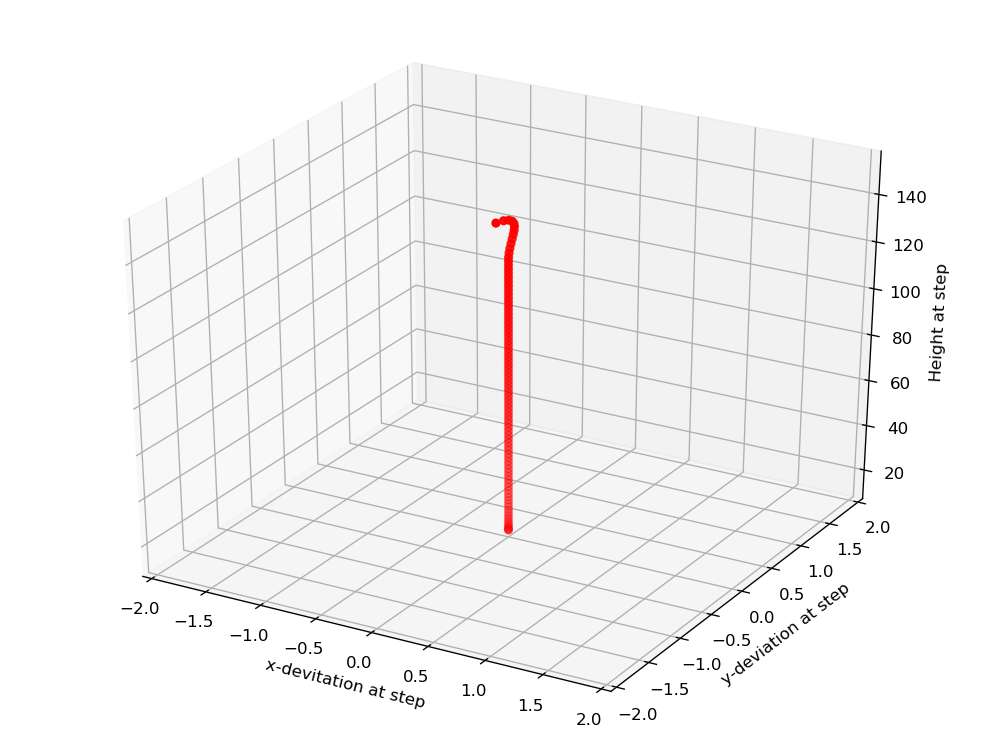

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6), dpi=120)
ax = Axes3D(fig)

ax.scatter(x, y, z, c='r')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(10,155)
ax.set_xlabel('x-devitation at step')
ax.set_ylabel('y-deviation at step')
ax.set_zlabel('Height at step')

plt.show()

In [15]:
#import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

steps = list(range(0, (len(t.traces[-1].rewards)), 1))
height = z

trace = go.Scatter(
    x = steps,
    y = height
)

data = [trace]

iplot(data)

/Users/mleske/anaconda3/envs/ai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [16]:
trace = go.Scatter3d(
    x=x, y=y, z=z,
    marker=dict(
        size=4,
        color=z,
        colorscale='Viridis',
    ),
    line=dict(
        color='#1f77b4',
        width=1
    )
)

data = [trace]

layout = dict(
    width=800,
    height=700,
    autosize=False,
    title='Drone takeoff',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            #range = [-.01,.01]
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            #range = [-.01,.01]
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            #range = [10,160]
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig)